# Face Mask Detection

built this model to use in my [real-time-face-mask-detection mini-project using opencv](https://github.com/hikmatullah-mohammadi/real-time-face-mask-detection), so I tried to keep it simple.

## Import required libraries / dependencies

In [ ]:
!pip install tensorflow tensorflow_addons --upgrade --quiet
!pip install transformers --upgrade --quiet
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [1]:
# import required libraries / dependencies
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2022-12-12 18:47:15.814819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 18:47:16.090826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-12-12 18:47:16.090892: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 18:47:17.523782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

2.11.0


## Generate the datasets, both the training and the test sets

In [3]:
# define the paths to the dataset.
ds_path = '/kaggle/input/face-mask-lite-dataset'

In [5]:
# Create dataset
image_size = (100, 100)
batch_size = 64

training_set = keras.preprocessing.image_dataset_from_directory(
    directory=ds_path,
    class_names=['without_mask', 'with_mask'],
    image_size=image_size,
    batch_size=batch_size,
    seed=1,
    subset='training',
    validation_split=0.2
)
test_set = keras.preprocessing.image_dataset_from_directory(
    directory=ds_path,
    class_names=['without_mask', 'with_mask'],
    image_size=image_size,
    batch_size=batch_size,
    seed=1,
    subset='validation',
    validation_split=0.2
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


2022-12-12 18:48:09.025987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


## Visualize some images from the training set

2022-12-12 18:48:20.287069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 482 of 512
2022-12-12 18:48:20.889988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


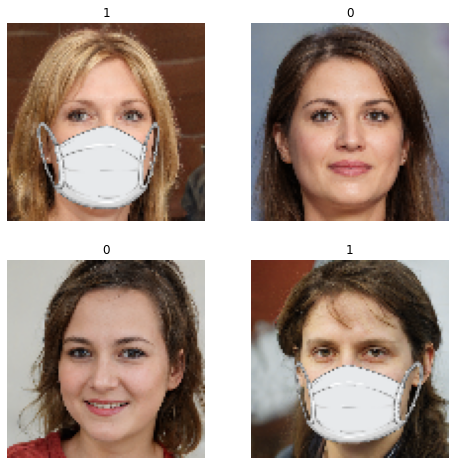

In [6]:
# visualize the training set
plt.figure(figsize=(8, 8))
    
for images, labels in training_set.take(1):
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'{int(labels[i])}')
        plt.axis('off')

----

## Build a model

In [7]:
# build the model
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(*image_size, 3)),
    
    # preprocessing
    layers.Rescaling(scale=1./255),
    
    # applying image data augmentation
    layers.RandomRotation(0.1),
    
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    layers.Flatten(),
    
    # output layer
    layers.Dense(1, activation='sigmoid')
])

In [8]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 32)      0         
                                                                 
 random_rotation (RandomRota  (None, 100, 100, 32)     0         
 tion)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0

## Train the model

In [9]:
epochs = 2

# compile the model
model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit the model
history = model.fit(training_set, validation_data=test_set, epochs=epochs, verbose=2)

Epoch 1/2


2022-12-12 19:07:51.745663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 394 of 512
2022-12-12 19:07:54.982801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


250/250 - 1205s - loss: 0.0438 - accuracy: 0.9791 - val_loss: 6.5119e-06 - val_accuracy: 1.0000 - 1205s/epoch - 5s/step
Epoch 2/2
250/250 - 1219s - loss: 3.7298e-05 - accuracy: 1.0000 - val_loss: 3.3075e-06 - val_accuracy: 1.0000 - 1219s/epoch - 5s/step


In [12]:
# Save the model for future use
model.save('./face-mask-detection-model.h5')
import pickle as pkl

filenm = 'face-mask-detection-model.pickle'
# Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(model, open(filenm, 'wb'))

print('Model saved!')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......random_rotation
.........vars
......rescaling
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                        

## Visualize the predicted images

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-12 19:34:22         4188
variables.h5                                   2022-12-12 19:34:22      1379680
metadata.json                                  2022-12-12 19:34:22           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......random_rotation
.........vars
......rescaling
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......v

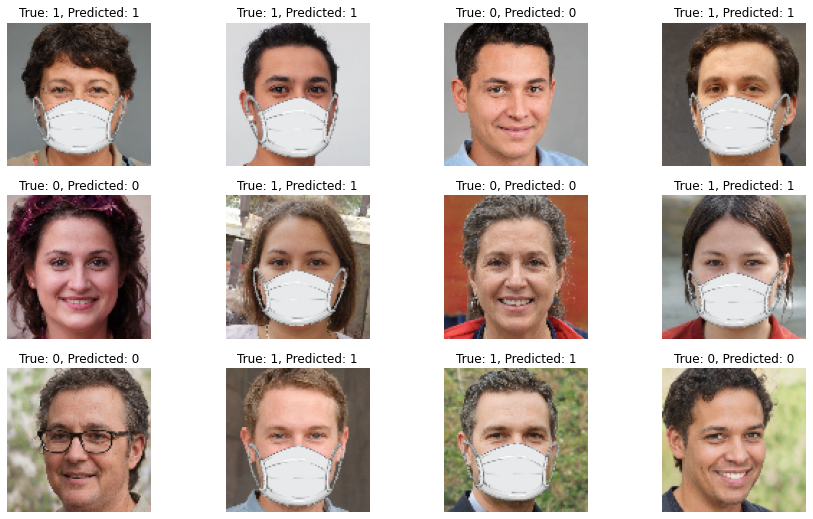

In [11]:
# visualize the predicted data
loaded_model = pkl.load(open('face-mask-detection-model.pickle', 'rb'))

plt.figure(figsize=(15, 9))

def predict(imgs):
    pred = []
    for i in loaded_model.predict(images.numpy().astype('uint8')):
        if i[0] > .5:
            pred.append(1)
        else:
            pred.append(0)
    return pred
    
for images, labels in test_set.take(1):
    pred = predict(images)
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'True: {int(labels[i])}, Predicted: {pred[i]}')
        plt.axis('off')

---

<div style='border-radius:10px;background:black;color:white;padding:25px'>
    Hey,<br>
    Thanks for your time reviewing my notebook.<br>
    Please don't hesitate to leave a comment if you have anything to share about the kernel. <br>
    Also, if you have time, please review my other works <a href='https://www.kaggle.com/hikmatullahmohammadi/code' target='_blank'>here</a>.<br><br>
    Happy coding :)<br>  
    <b>I have built a mini-project by opencv(cv2) to detect face mask in real time. <a href='https://github.com/hikmatullah-mohammadi/real-time-face-mask-detection'>Here</a> is the link to its Github repository</b>
</div>